## License

Copyright 2020 Google LLC

Licensed under the the Apache License v2.0 with LLVM Exceptions (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://llvm.org/LICENSE.txt

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [724]:
import requests
import os
import logging
import argparse
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [725]:
cache_file = "cache.json"
token = f'Bearer {os.getenv("BUILDKITE_API_TOKEN")}'
builds = []

In [726]:
if os.path.exists(cache_file):
    with open(cache_file) as f:
        builds = json.load(f)
        print(f'loaded {len(builds)} entries') 

loaded 13566 entries


In [727]:
# load new jobs from Buildkite API
max_pages = 2000
if True:
    existing = set()
    for j in builds:
        existing.add(j['id'])

    # uncomment to reset
#     builds = []
#     existing = set()
    page = 1
    stop = False
    while page <= max_pages:
        print('loading page', page)
        re = requests.get('https://api.buildkite.com/v2/organizations/llvm-project/builds',
                          params={'page': page},
                          headers={'Authorization': token})
        if re.status_code != 200:
            print('response status', re.status_code, re)
            break
        x = re.json()
        if x == []:
            print('empty response')
            break
        for j in x:
            if j['id'] in existing:
#                 print('found existing job', j['id'])
                # load some more pages as some of them might be running before and wasn't added.                
                max_pages = min(page + 5, max_pages)
            else:
                # skip running jobs            
                if (j['state'] == 'running') or (j['state'] == 'scheduled'):
                    print(j['web_url'], 'is', j['state'], ', skipping')
                    continue
                builds.append(j)
        page += 1
    print(len(builds), 'jobs in total')    
    with open(cache_file, 'w') as f:
        json.dump(builds, f)
    print(f'saved {len(builds)} entries')

loading page 1
loading page 2
loading page 3
https://buildkite.com/llvm-project/llvm-master-build/builds/723 is running , skipping
https://buildkite.com/llvm-project/llvm-master-build/builds/721 is running , skipping
https://buildkite.com/llvm-project/llvm-master-build/builds/719 is running , skipping
loading page 4
https://buildkite.com/llvm-project/llvm-master-build/builds/717 is running , skipping
https://buildkite.com/llvm-project/llvm-master-build/builds/715 is running , skipping
loading page 5
loading page 6
loading page 7
loading page 8
loading page 9
loading page 10
13706 jobs in total
saved 13706 entries


In [728]:
d = {
    'id': [],
    'number': [],
    'pipeline': [],
}

jobs = {
    'pipeline': [],
    'name': [],
    'step_key': [],
    'state': [],
    'exit_status': [],
    'agent_id': [],
    
    'agent_name': [],
    'runnable_at': [],
    'started_at': [],
    'wait_duration': [],
    'finished_at': [],
    'run_duration': [],
}

sec = np.timedelta64(1, 's')

for b in builds:
    env = b['env']
    if 'ph_windows_agents' not in env:
        continue
    if 'scripts_branch' not in env:
        continue
    d['id'].append(b['id'])
    d['number'].append(b['number'])
    d['pipeline'].append(b['pipeline']['slug'])
    for x in b['jobs']:
        if x['state'] in ['waiting_failed', 'canceled', 'skipped', 'broken']:
            continue
        try:
            jobs['pipeline'].append(b['pipeline']['slug'])
            jobs['name'].append(x['name'])
            jobs['step_key'].append(x['step_key'] if 'step_key' in x else '')
            jobs['state'].append(x['state'] )
            jobs['exit_status'].append(x['exit_status'] if 'exit_status' in x else -1)
            jobs['agent_id'].append(x['agent']['id'] if 'agent' in x else '')
            jobs['agent_name'].append(x['agent']['name'] if 'agent' in x else '')
            runnable = np.datetime64(x['runnable_at'].replace('Z', ''))
            started = np.datetime64(x['started_at'].replace('Z', ''))
            finished = np.datetime64(x['finished_at'].replace('Z', ''))
            jobs['runnable_at'].append(runnable)
            jobs['started_at'].append(started)
            jobs['wait_duration'].append((started - runnable) / sec)
            jobs['finished_at'].append(finished)
            jobs['run_duration'].append((finished - started) / sec)
        except Exception as e:
            print(x)
            raise e            
jobs = pd.DataFrame(jobs)

In [729]:
jobs.pipeline.unique()

array(['llvm-master-build'], dtype=object)

In [730]:
jobs

,pipeline,name,step_key,state,exit_status,agent_id,agent_name,runnable_at,started_at,wait_duration,finished_at,run_duration
0,llvm-master-build,:seedling: setup,None,passed,0,f20d42d3-31cb-4e46-a3d6-699877e7b283,premerge-debian-77f64f444-fm624-1,2020-07-27 18:10:16,2020-07-27 18:15:44.928,328.928,2020-07-27 18:15:47.797,2.869
1,llvm-master-build,:windows: build and test windows,windows,passed,0,c9e48cee-e909-45b2-aa23-0d7335786499,we32n1b,2020-07-27 18:15:47,2020-07-28 01:36:57.687,26470.687,2020-07-28 02:26:08.750,2951.063
2,llvm-master-build,:seedling: setup,None,passed,0,f20d42d3-31cb-4e46-a3d6-699877e7b283,premerge-debian-77f64f444-fm624-1,2020-07-27 18:10:15,2020-07-27 18:15:34.989,319.989,2020-07-27 18:15:37.721,2.732
3,llvm-master-build,:windows: build and test windows,windows,passed,0,d4d0a0a4-255b-4fdd-8aba-abb00ba0bf34,we16c2b,2020-07-27 18:15:37,2020-07-28 03:13:59.996,32302.996,2020-07-28 04:14:12.521,3612.525
4,llvm-master-build,:seedling: setup,None,passed,0,f20d42d3-31cb-4e46-a3d6-699877e7b283,premerge-debian-77f64f444-fm624-1,2020-07-27 18:10:14,2020-07-27 18:15:25.094,311.094,2020-07-27 18:15:27.918,2.824
...,...,...,...,...,...,...,...,...,...,...,...,...
189,llvm-master-build,:windows: build and test windows,windows,passed,0,42f6f98d-15bd-4ad4-ac48-8626a752a154,w16c2-1,2020-07-29 18:22:31,2020-07-29 20:23:50.686,7279.686,2020-07-29 21:23:50.271,3599.585
190,llvm-master-build,:seedling: setup,None,passed,0,db5829eb-04bf-4700-9bec-423258de4a7d,premerge-debian-77f64f444-vxgx4-1,2020-07-29 18:21:47,2020-07-29 18:22:09.243,22.243,2020-07-29 18:22:12.321,3.078
191,llvm-master-build,:windows: build and test windows,windows,passed,0,42f6f98d-15bd-4ad4-ac48-8626a752a154,w16c2-1,2020-07-29 18:22:12,2020-07-29 19:24:00.345,3708.345,2020-07-29 20:23:45.967,3585.622
192,llvm-master-build,:seedling: setup,None,passed,0,db5829eb-04bf-4700-9bec-423258de4a7d,premerge-debian-77f64f444-vxgx4-1,2020-07-29 18:21:45,2020-07-29 18:21:49.190,4.190,2020-07-29 18:21:52.862,3.672


In [731]:
ds = jobs[jobs['pipeline'] == 'llvm-master-build'][jobs['step_key'] == 'windows'][jobs['state']=='passed'][~jobs['agent_name'].str.startswith('buildkite-')][jobs['started_at'] > np.datetime64('2020-01-22')]
ds = ds.drop_duplicates()
# remove one slowest run (repo checkout)
# t = ds.loc[ds.groupby(["agent_name"])["run_duration"].idxmax()]
# ds = pd.concat([ds, t]).drop_duplicates(keep=False)

/usr/local/google/home/goncharov/etc/merge-checks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


/usr/local/google/home/goncharov/etc/merge-checks/venv/lib/python3.7/site-packages/seaborn/categorical.py:2971: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


(0.0, 5877.15505)

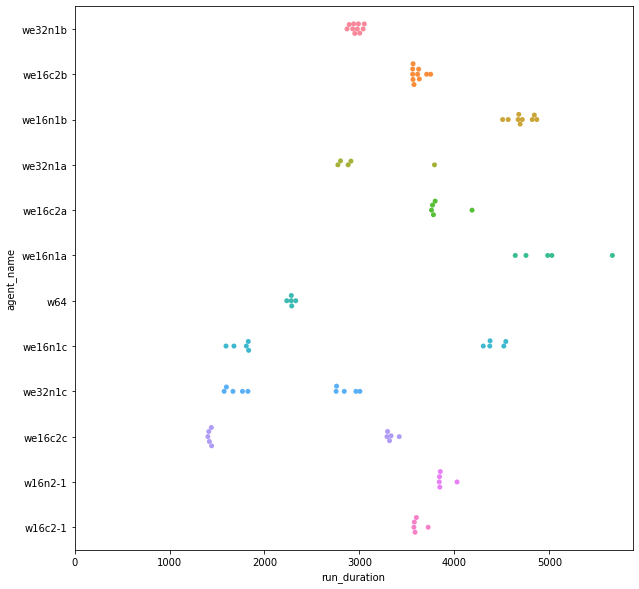

In [732]:
fig, ax = plt.subplots(figsize=(10,10)) # size of the plot (width, height)

sns.swarmplot(
      ax=ax,
      x='run_duration',
      y='agent_name',
      split=True,
      data=ds)

plt.xlim(0, None)

In [733]:
t = pd.pivot_table(ds, values=['run_duration'], index=['agent_name'],
                    aggfunc=[np.median, np.mean, np.std, np.count_nonzero])
t = t.reindex(t.sort_values(by=('median', 'run_duration'), ascending=False).index)
t

,median,mean,std,count_nonzero
,run_duration,run_duration,run_duration,run_duration
agent_name,,,,
we16n1a,4982.7380,5013.848800,396.926050,5.0
we16n1b,4692.7930,4707.102222,121.624149,9.0
w16n2-1,3846.2090,3881.809600,81.657742,5.0
we16c2a,3779.3110,3858.373400,183.822602,5.0
we16c2b,3593.5200,3615.016200,66.460005,10.0
w16c2-1,3585.6220,3612.092800,63.120688,5.0
we16n1c,3068.6440,3085.927100,1412.888086,10.0
we32n1b,2964.4520,2964.178300,59.215712,10.0


```
// TODO: try with w64 w/o AV (temporary disabled)
w1 - 16 - non ssd 100 + ssd
w1a - 16 - non ssd 100 + ssd - AV (temp)
w4a - 16 - non ssd 100 + ssd - AV
w16-1 - 16 - non sdd 200 + ssd
w32-1 - 32 - non ssd 100 + ssd
w32-2 - 32 - non ssd 100 + ssd - AV
w32-2d - 32 - non ssd 200 + ssd
w64 - 64 - ssd 200 + ssd 
w64a - 64 - ssd 200 + ssd - AV (temp)
wh63-3 - 64 low ram - non ssd 100 + ssd - AV

buildkite-windows-16n1-exp
gcloud beta compute instances create "${NAME}" \
  --project="${GCP_PROJECT}" \
  --zone="${GCP_ZONE}" \
  --machine-type=n1-standard-16 \
  --local-ssd=device-name=local-ssd-0 \
  --image=windows-server-2019-dc-for-containers-v20200714 \
  --image-project=windows-cloud \
  --boot-disk-size=200GB --boot-disk-type=pd-ssd

buildkite-32-experimental-1
gcloud beta compute instances create "${NAME}" \
  --project="${GCP_PROJECT}" \
  --zone="${GCP_ZONE}" \
  --machine-type=n1-standard-32 \
  --local-ssd=device-name=local-ssd-0 \
  --image=windows-server-2019-dc-for-containers-v20200714 \
  --image-project=windows-cloud \
  --boot-disk-size=200GB --boot-disk-type=pd-ssd

  
buildkite-16c2-exp
gcloud beta compute instances create "${NAME}" \
  --project="${GCP_PROJECT}" \
  --zone="${GCP_ZONE}" \
  --machine-type=c2-standard-16 \
  --local-ssd=device-name=local-ssd-0 \
  --local-ssd=interface=SCSI \
  --image=windows-server-2019-dc-for-containers-v20200714 \
  --image-project=windows-cloud \
  --boot-disk-size=200GB --boot-disk-type=pd-ssd
  
...a: as is D:/ is a workdir (ealy run with full cache build)
...b: C:/ws as a workdir, no cache
```
